# Posterior sampling for Gaussian Mixture Model using Gibbs sampler

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st

import importlib
import GMM_gibbs as gmm

In [261]:
def plot_points(zs,K,X,title):
    fig, ax = plt.subplots()
    datasets = []
    for i in range(K):
        # Assigned indices
        assigned_indices = (zs == i)
        datasets.append(X[assigned_indices, :])

    # Now let's put the scatter plots onto the scene.
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for j,data in enumerate(datasets):
        ax.scatter(data[:, 0], data[:, 1], color=colors[j])

    ax.set_title(title)

    plt.show()
    
def plot_logprob(iter_prob):
    fig, ax = plt.subplots()
    iteration_vec = range(0, len(iter_prob))
    ax.plot(iteration_vec, iter_prob)
    ax.set_title('Log Probability vs. Iterations')

    plt.show()

In [262]:
def generate_test_data():
    """ This is the a test script used for me to generate test data"""
    # All of these will be assumed 2-D data
    # Let's generate a mixture of three gaussians
    u_0 = np.array([-2.0,-2.0])
    u_1 = np.array([0.0,2.0])
    u_2 = np.array([2.0,-2.0])

    # sigmas for each of the data
    sigmas = [1, 1, 1]
    points_per_cluster = 100

    # Now initialize the data variables
    data0 = np.random.randn(points_per_cluster,2)*sigmas[0] + u_0
    data1 = np.random.randn(points_per_cluster,2)*sigmas[1] + u_1
    data2 = np.random.randn(points_per_cluster,2)*sigmas[2] + u_2
    X = np.vstack((data0, data1, data2))

    # Now random init the cluster assignments
    rand_Y = np.random.randint(0, 3, points_per_cluster*3)
    return X, rand_Y

In [263]:
X, Y = generate_test_data()

In [264]:
X.shape, Y.shape

((300, 2), (300,))

### Algorithm 1
- Sample mixture locations $\mu_k$ 
- Sample mixing coefficents $\pi_k$
- Sample cluster assignements $z_n$

Initialize variables

In [269]:
K = 3
N = X.shape[0]

# GMM params
mus = np.array([np.random.rand() * np.ones(X.shape[1]) for k in range(K)])
# mus = np.array([1 * np.ones(K), 15 * np.ones(K)], dtype='float')
sigmas = np.array([np.diag(np.ones(X.shape[1])) for k in range(K)], dtype='float')
lambdas = np.array([np.linalg.inv(sigmas[k]) for k in range(K)])
# pis = np.array(0.5 * np.ones(K) )  # Mixing probs.
pis = np.ones(K)/ float(K)
zs = np.zeros([N])  # Assignments
for i in range(N):
    z = np.random.multinomial(n=N, pvals=pis).argmax()
    zs[i] = z
Y = zs.copy()
# Priors
alpha =np.ones(K)
pis = np.random.dirichlet(alpha)
mus0 = np.ones((K, X.shape[1]))
sigmas0 = np.array([np.diag(np.ones(X.shape[1])) for k in range(K)], dtype='float')
lambdas0 = np.array([np.linalg.inv(sigmas0[k]) for k in range(K)])

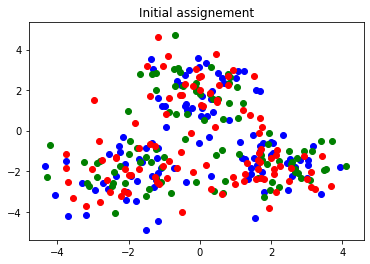

In [270]:
plot_points(zs,K,X,title = 'Initial assignement')


### Gibbs sampler

In [271]:
sigma = 1
normalizer = (1 / ((sigma ** 2) * np.sqrt(2 * np.pi)))
iter_prob = []
T = 50

In [272]:
for it in range(T):
    # Sample from full conditional of assignment
    # z ~ p(z) \propto pi*N(y|pi)
    probs = np.zeros([N, K])

    for k in range(K):
        p = pis[k] * st.multivariate_normal.pdf(X, mean=mus[k], cov=sigmas[k])
        probs[:, k] = p

    # Normalize
    probs /= np.sum(probs, axis=1)[:, np.newaxis]

    # For each data point, draw the cluster assignment
    for i in range(N):
        z = np.random.multinomial(n=1, pvals=probs[i]).argmax()
        zs[i] = z

    # Sample from full conditional of cluster parameter
    # Assume fixed covariance => posterior is Normal
    # mu ~ N(mu, sigma)
    Ns = np.zeros(K, dtype='int')

    for k in range(K):
        # Gather all data points assigned to cluster k
        Xk = X[zs == k]
        Ns[k] = Xk.shape[0]

        # Covariance of posterior
        lambda_post = lambdas0[k] + Ns[k]*lambdas[k]
        cov_post = np.linalg.inv(lambda_post)

        # Mean of posterior
        left = cov_post
        right = lambdas0[k] @ mus0[k] + Ns[k]*lambdas[k] @ np.mean(Xk, axis=0)
        mus_post = left @ right

        # Draw new mean sample from posterior
        mus[k] = st.multivariate_normal.rvs(mus_post, cov_post)

    # Sample from full conditional of the mixing weight
    # pi ~ Dir(alpha + n)
    pis = np.random.dirichlet(alpha + Ns)
    
    # Calculate log-likelihood
    log_probs = np.zeros(X.shape[0])
    for i in range(0, X.shape[0]):
       # Calculate the sum of the lob probabilities
        clust = int(zs[i])
        d = np.linalg.norm(X[i, :] - mus[clust, :])
        log_probs[i] =  np.log(np.exp(-(d ** 2) / (2 * (sigma ** 2))) * normalizer)

    iter_prob.append(log_probs.sum())

for k in range(K):
    print('{} data in cluster-{}, mean: {}'.format(Ns[k], k, mus[k]))

103 data in cluster-0, mean: [ 1.92940753 -1.86083784]
97 data in cluster-1, mean: [-2.02751638 -2.0907404 ]
100 data in cluster-2, mean: [0.05081807 1.91860197]


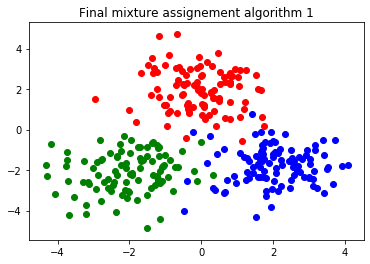

In [273]:
plot_points(zs,K,X,title = 'Final mixture assignement algorithm 1')

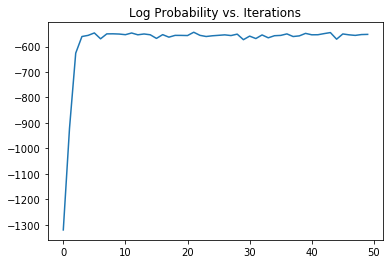

In [274]:
plot_logprob(iter_prob)


### Algorithm 2: collapse $\pi$
- Sample mixture locations $\mu_k$ 
- Sample cluster assignement $z_n$

In [275]:
importlib.reload(gmm)

<module 'GMM_gibbs' from '/Users/cdebacco/apmla_2021/lecture_material/L3/GMM_gibbs.py'>

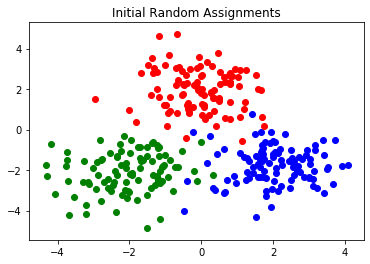

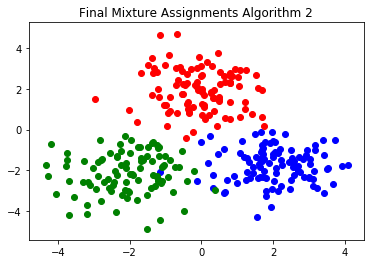

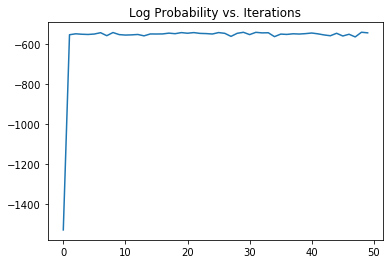

(array([[ 2.0191832 , -1.674284  ],
        [-1.97093657, -2.06120603],
        [-0.06365975,  2.00742685]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

In [276]:
gs = gmm.MixGaussGibbsSampler(X, zs.astype('int'),sigma=1, lam=1, burn_in=50, lag=10)
gs.perform_gibbs_sampling(iterations=T)

### Compare mus algo1 and algo2

In [277]:
print(gs.u_locations)

[[ 2.0191832  -1.674284  ]
 [-1.97093657 -2.06120603]
 [-0.06365975  2.00742685]]


In [278]:
for k in range(K):
    print(mus[k])

[ 1.92940753 -1.86083784]
[-2.02751638 -2.0907404 ]
[0.05081807 1.91860197]
